# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)+1

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 定义数据生成器

In [6]:
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            y[i] = [characters.find(x) for x in random_str]
        
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), np.ones(batch_size)*n_len], np.ones(batch_size)

# 测试生成器

In [5]:
[X_test, y_test, _, _], _  = next(gen(1))
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title(''.join([characters[x] for x in y_test[0]]))

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

# 定义 CTC Loss

In [7]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 定义网络结构

In [8]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    # x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    # x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
print("Conv_shape=", conv_shape)
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

# gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
# gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru1_b')(x)
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(x)
gru1_merged = merge([gru_1, gru_1b], mode='sum')

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
x = merge([gru_2, gru_2b], mode='concat')
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')

Conv_shape= (?, 17, 6, 32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


# 网络结构可视化

In [9]:
# import pydot
from IPython.display import SVG, Image
# from keras.utils.visualize_util import plot, model_to_dot
from keras.utils.vis_utils import plot_model

# 1.需要安装：pip install graphviz和pip install pydot
# 2.安装graphviz软件:官网地址为http://www.graphviz.org/下载安装版，自动增加环境变量
# 3.引入的名称改变：from keras.utils.vis_utils import plot_model

# plot(model, show_shapes=True)
# Image('model.png')
plot_model(model, to_file='model.png', show_shapes=True)
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 导入权值

这是之前跑好了的模型

In [8]:
model.load_weights('model.h5')

# 训练模型

In [14]:
def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen(128)
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
    return batch_acc / batch_num

In [15]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print
        print('acc: %f%%'%acc)

evaluator = Evaluate()

In [ ]:
from keras.callbacks import EarlyStopping

model.fit_generator(gen(128), samples_per_epoch=2560, nb_epoch=1,
                    callbacks=[EarlyStopping(patience=10), evaluator],
                    validation_data=gen(), nb_val_samples=1280)

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., validation_data=<generator..., steps_per_epoch=2560, epochs=1, validation_steps=1280)`
  after removing the cwd from sys.path.


Epoch 1/1
 306/2560 [==>...........................] - ETA: 29459s - loss: 15.9848

In [11]:
model.fit_generator(gen(128), samples_per_epoch=51200, nb_epoch=200,
                    callbacks=[EarlyStopping(patience=10), evaluator],
                    validation_data=gen(), nb_val_samples=1280)

NameError: name 'EarlyStopping' is not defined

# 测试模型

[(14, 'E'),
 (30, 'U'),
 (36, ' '),
 (26, 'Q'),
 (34, 'Y'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

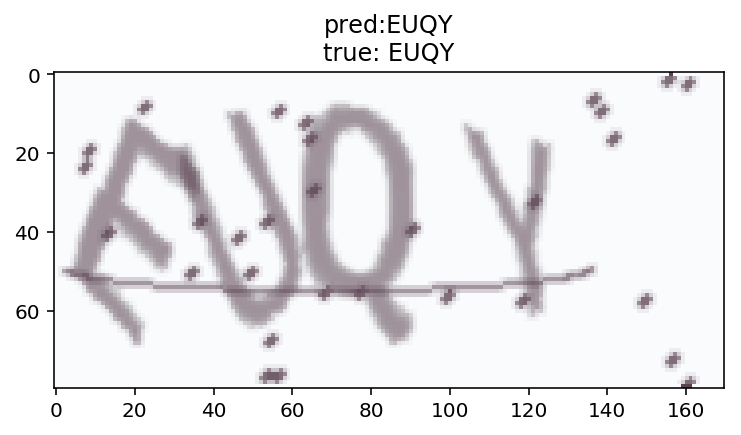

In [18]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
y_pred = y_pred[:,2:,:]
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

# 计算模型总体准确率

In [21]:
evaluate(base_model)

0.41093750000000001

In [16]:
model.save('model.h5')